# Lab 3 — recommender systems

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np


%matplotlib inline
plt.style.use("ggplot")


What does the data look like?

In [2]:
!hdfs dfs -cat /ix/ml-20m/ratings.txt | head -n 5 # tail -n 2

{"movieId": 2, "userId": 1, "timestamp": 1112486027, "rating": 3.5}
{"movieId": 29, "userId": 1, "timestamp": 1112484676, "rating": 3.5}
{"movieId": 32, "userId": 1, "timestamp": 1112484819, "rating": 3.5}
{"movieId": 47, "userId": 1, "timestamp": 1112484727, "rating": 3.5}
{"movieId": 50, "userId": 1, "timestamp": 1112484580, "rating": 3.5}
cat: Unable to write to output stream.


In [3]:
data = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)

In [4]:
data.count()


20000263

In [5]:
# 3.5
user_counts = data.map(lambda x: (x["userId"],_)).countByKey()

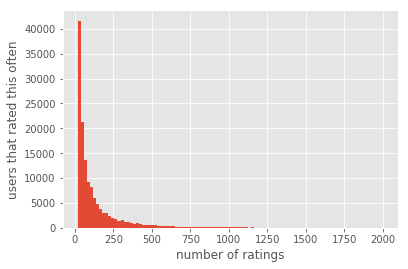

In [ ]:
user_counts = np.array(list(user_counts.values()))
user_counts_s = user_counts[user_counts <= 2000]
plt.hist(user_counts_s, bins = 100)
plt.xlabel("number of ratings")
plt.ylabel("users that rated this often")
plt.show()

In [ ]:
item_counts = data.map(lambda x: (x["movieId"],_)).countByKey()

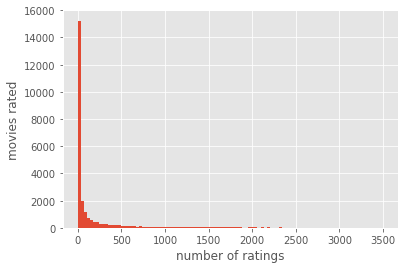

In [ ]:
item_counts = np.array(list(item_counts.values()))
item_counts_s = item_counts[item_counts <= 3500]
plt.hist(item_counts_s, bins = 100)
plt.xlabel("number of ratings")
plt.ylabel("movies rated")
plt.show()

In [ ]:
%run rate-movies.py

Please rate the following movies.
1 (worst) -- 5 (best), or 0 if not seen

Toy Story (1995)
Adventure, Animation, Children, Comedy, Fantasy


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [ ]:
!hdfs dfs -put my-ratings.txt

put: `my-ratings.txt': File exists


In [ ]:
!hdfs dfs -cat /ix/ml-20m/ratings.txt | tail -n 2


{"movieId": 70286, "userId": 138493, "timestamp": 1258126944, "rating": 5.0}
{"movieId": 71619, "userId": 138493, "timestamp": 1255811136, "rating": 2.5}


In [ ]:
my_ratings = sc.textFile("my-ratings.txt").map(json.loads)

In [ ]:
data_set = sc.union([data,my_ratings])

In [ ]:
# 3.6
last_digit_tuples = data_set.map(lambda x: (x['timestamp'] % 10, x['userId'], x['movieId'], x['rating']))
last_digit_tuples.countByKey()

In [ ]:
# use 8,9 as test data
train_data = data_set.filter(lambda x: x['timestamp'] % 10 < 8)
test_data  = data_set.filter(lambda x: x['timestamp'] % 10 >= 8)

In [ ]:
# 3.7
#mean
mean = train_data.map(lambda x: x["rating"]).sum() / train_data.count()
print("The training data has a mean of {}.".format(mean))

In [ ]:
# user bias
ratings_per_user = train_data.map(lambda x: (x["userId"],x["rating"] - mean)).groupByKey().map(lambda x : (x[0], list(x[1]))).collect()

In [ ]:
ratings_per_user = sc.parallelize(ratings_per_user)

In [ ]:
user_bias = ratings_per_user.map(lambda x : (x[0], sum(x[1]) / len(x[1]) )).collect()

In [ ]:
user_bias_sorted = sc.parallelize(user_bias).sortByKey().collect()

In [ ]:
d_u = {}
for i in user_bias_sorted:
    d_u[i[0]] = i[1]

In [ ]:
# remaining item bias
ratings_per_item = train_data.map(lambda x: (x["movieId"],x["rating"] - mean - d_u[x["userId"]])).groupByKey().map(lambda x : (x[0], list(x[1]))).collect()


In [ ]:
ratings_per_item = sc.parallelize(ratings_per_item)

In [ ]:
item_bias = ratings_per_item.map(lambda x : (x[0], sum(x[1]) / len(x[1]) )).collect()

In [ ]:
item_bias_sorted = sc.parallelize(item_bias).sortByKey().collect()
d_i = {}
for i in item_bias_sorted:
    d_i[i[0]] = i[1]

In [ ]:
# how many parameters


In [ ]:
# predict ratings for every user/movie pair

pred = train_data.map(lambda x: (x["userId"], x["movieId"], mean + d_u[x["userId"]] + d_i[x["movieId"]]))


In [ ]:
pred.take(2)

In [ ]:
# 3.8
#(userId, movieId, rating)
def error(pred, val):
    pred_with_keys = pred.map(lambda x: ((x[0], x[1]), x[2]))
    val_with_keys = val.map(lambda x: ((x[0], x[1]), x[2]))
    
    data = val_with_keys.join(pred_with_keys)
    diff = data.map(lambda x: (x[0][0], (x[1][0] - x[1][1])**2))
    diff_per_user = diff.groupByKey().map(lambda x : (x[0], list(x[1])))
    diff_per_user = diff_per_user.map(lambda x: np.sqrt(sum(x[1]) /len(x[1])))
    res = diff_per_user.mean()
    return res
    

    

In [ ]:
val = train_data.map(lambda x: (x["userId"], x["movieId"], x["rating"]))
e = error(pred, val)
e

In [ ]:
# 3.9
from pyspark.mllib.recommendation import *
ranks = [5, 10, 15, 20, 25]

In [ ]:
models = {}
preds = {}
errors = {}

train = train_data.map(lambda x: Rating(x["userId"],x["movieId"],x["rating"])) 
test = test_data.map(lambda x: (x["userId"],x["movieId"],x["rating"]))  
val_features = test_data.map(lambda x: (x["userId"],x["movieId"]))  
val_labels = test_data.map(lambda x: (x["rating"]))  

for rank in ranks:
    print("training model with rank: {}".format(rank))
    model = ALS.train(ratings= train, rank= rank, lambda_= 0.0001)
    models[rank] = model

    print("predicting with model with rank: {}".format(rank))
    pred_ratings = model.predictAll(val_features)
    preds[rank] = pred_ratings

    print("calculating error for rank: {}".format(rank))
    pred_ratings = pred_ratings.map(lambda x: (x.user, x.product, x.rating))
    e = error(pred_ratings, test)
    errors[rank] = e
    
    print('for rank = {}, the error is {}'.format(rank, e))



In [ ]:
# How accurate are the predicted ratings? Can you explain the phenomenon?

In [ ]:
# rank 5 with lambda_ 10.0
model = ALS.train(ratings= train, rank= 5, lambda_= 10.0)
pred_ratings = model.predictAll(val_features)
pred_ratings = pred_ratings.map(lambda x: (x.user, x.product, x.rating))
e = error(pred_ratings, test)

print("For a rank of 5 and lambda 10.0 the error is {}".format(e))

In [ ]:
# What happens to the predicted ratings, and why?

In [ ]:
lambdas = [0.00001, 0.001, 0.01, 0.1, 1]
for l in lambdas:
    print("training model with lambda: {}".format(l))
    model = ALS.train(ratings= train, rank= rank, lambda_= 0.0001)
    models[rank] = model

    print("predicting with model with lambda: {}".format(l))
    pred_ratings = model.predictAll(val_features)
    preds[rank] = pred_ratings

    print("calculating error for lambda: {}".format(l))
    pred_ratings = pred_ratings.map(lambda x: (x.user, x.product, x.rating))
    e = error(pred_ratings, test)
    errors[rank] = e
    
    print('for lambda = {}, the error is {}'.format(l, e))

In [ ]:
lambdas = [0.0005, 0.00075, 0.00125, 0.0015]
for l in lambdas:
    print("training model with lambda: {}".format(l))
    model = ALS.train(ratings= train, rank= rank, lambda_= 0.0001)
    models[rank] = model

    print("predicting with model with lambda: {}".format(l))
    pred_ratings = model.predictAll(val_features)
    preds[rank] = pred_ratings

    print("calculating error for lambda: {}".format(l))
    pred_ratings = pred_ratings.map(lambda x: (x.user, x.product, x.rating))
    e = error(pred_ratings, test)
    errors[rank] = e
    
    print('for lambda = {}, the error is {}'.format(l, e))

The lambda with the smallest error is found at 0.001.


In [ ]:
# What improvement do you get over the error of the baseline recommender system?

In [ ]:
# 3.10
!hdfs dfs -cat /ix/ml-20m/movies.txt | head -n 5 # tail -n 2

In [ ]:
movies = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)

In [ ]:
movies.take(2)

In [ ]:
d_movies = {}
for m in movies.collect():
    d_movies[m["movieId"]] = m["title"]

In [ ]:
d_movies_genre = {}
for m in movies.collect():
    d_movies_genre[m["movieId"]] = m["genres"]

In [ ]:
d_movies[1]

In [ ]:
model = ALS.train(ratings= train, rank= 5, lambda_= 0.001)

In [ ]:
recommendations_123 = model.recommendProducts(user=123, num=10)

In [ ]:
for r in recommendations_123:
    print(d_movies[r.product])

In [ ]:
for r in recommendations_123:
    print(d_movies_genre[r.product])

In [ ]:
# What kind of movies does the model think the user will like?

In [ ]:
recommendations_myself = model.recommendProducts(user=138494, num=10)
for r in recommendations_123:
    print(d_movies[r.product], d_movies_genre[r.product])

In [ ]:
# What do you think of your recommendations? :-) 

In [ ]:
# 3.11

In [ ]:
import pickle
with open("selected-movies.pickle", "rb") as f:
    selected_movies = pickle.load(f,encoding="utf-8")

In [ ]:
selected_movies[0:2]

In [ ]:
movie_ids = [m[0] for m in selected_movies]

In [ ]:
model = ALS.train(ratings= train, rank= 2, lambda_= 0.001)

In [ ]:
features = model.productFeatures().filter(lambda x: x[0] in movie_ids).collect()